<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [115]:
!pip install pymorphy2 --quiet

In [116]:
import sys
import re
import matplotlib.pyplot as plt
import pandas as pd
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud

In [117]:
data = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_original_RU.csv')
data.sample(10)

,comment,toxic
4857,В москве. На S- классе ездит. На передних сиде...,0.0
7734,0 от сердца к солнцу!\n,0.0
3547,да хз) может раньше была такая тенденция) я ли...,0.0
618,донатить петушильникову в голосину с дебила\n,0.0
5575,"Просто рассеянские поцреоты привыкли, что им г...",1.0
7050,"Ну как можно не видеть, если ты не в подвале ж...",0.0
8660,"Это частный случай, спрашивают то их все равно...",0.0
10917,Вот и ссылка на оригинал (но это не точно)http...,0.0
11320,"Из таких вот не помню, не знаю, не слышал, поп...",0.0
9245,А они нафиг не нужны стали. Теперь более продв...,0.0


In [118]:
data['comment'] = data['comment'].values.astype('U')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


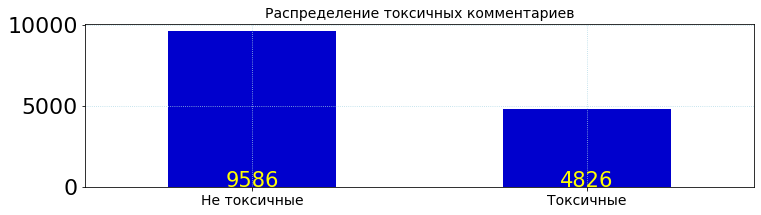

In [119]:
fig, ax = plt.subplots(figsize=(12, 3))

toxic = (data['toxic'].value_counts()).plot(kind='bar',  
                                   color='mediumblue').set_title(
    'Распределение токсичных комментариев', 
    fontdict={'fontsize': 14}
)
ax.set_xticklabels(['Не токсичные', 'Токсичные'], rotation=0, fontsize=14, )
plt.grid(color='lightblue', linestyle=':')
plt.text(0, 1, (data['toxic'].value_counts())[0], horizontalalignment='center', fontsize=21, color='yellow')
plt.text(1, 1, (data['toxic'].value_counts())[1], horizontalalignment='center', fontsize=21, color='yellow')
plt.show()

In [120]:
print('Количество дубликатов -', data.duplicated().sum())

Количество дубликатов - 0


In [121]:
morph = pymorphy2.MorphAnalyzer()
def lemmatize_word(word: str) -> str:
    try:
        p = morph.parse(word)[0]
        return p.normal_form 
    except:
        return word

In [122]:
def clear_and_lemmatize_text(text):
    text= text.lower()
    clear = re.sub(r'[^а-яА-Я]', ' ', text) # все кроме букв
    clear = re.sub(r"\s+[а-яА-Я]\s+", ' ', clear) # одиночные буквы
    clear = re.sub(r'\s+', ' ', clear) # лишние пробелы
     
    return ' '.join([lemmatize_word(word) for word in clear.split(' ')])

In [123]:
%%time
data['comment'] = data['comment'].apply(clear_and_lemmatize_text)

CPU times: user 1min 21s, sys: 278 ms, total: 1min 21s
Wall time: 1min 22s


In [124]:
data.sample(10)

,comment,toxic
14217,емедленно извиниться перед мнение шваль да в к...,1.0
2265,парфена всегда очень тонко макать хохлов помои...,1.0
11033,тут неизвестно за что именно она уволить не ис...,0.0
1731,и как бонус регулярный реклама яндекс обрыгало...,1.0
5323,ну многие льгота многодетный предусматривать г...,0.0
9407,эх молодость вспомнить заниматься дискотека го...,0.0
5389,добрый время сутки как можно связаться,0.0
10659,да если обратить внимание на первый предложени...,0.0
930,алло дорога только что по радио передать что о...,0.0
5617,бан блядь кроль за такой хуйня схс крол,1.0


In [125]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
data=data.astype({'toxic': 'int64'})
data.to_csv(FILE_NAME_CLEAR_DATA, encoding='utf-8', index=False)
# files.download(FILE_NAME)

**Загружаем ощищенные данные**

In [126]:
FILE_NAME_CLEAR_DATA='toxic_comment_RU_cleaned.csv'
df = pd.read_csv('https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_cleaned_RU.csv')
df.sample(10)

,comment,toxic
8935,к счастие или сожаление не сильный фанат рпг ж...,0
4637,так сейчас тесть каждый лето гонять на поезд д...,0
784,парашный ватный дебил плиз,1
9645,там оценка не ставить просто зач но посещение ...,0
13948,о есть деанон это петух,1
9791,пенсионный возраст это печально для для активн...,0
13647,гитлер самый совершенный правитель история чел...,1
12635,надо быть напугать хороший дочь проститутка че...,1
7964,а вот думать куда мой посылка пропасть из кита...,0
13493,решение работать уже сегодняшний день,0


**Взвесим tf-idf**

In [127]:
count_idf_neutral = TfidfVectorizer(min_df=3, max_df=0.8)
count_idf_toxic = TfidfVectorizer(min_df=3, max_df=0.8)

tf_idf_neutral = count_idf_neutral.fit_transform(df.query('toxic == 0')['comment'])
tf_idf_toxic = count_idf_toxic.fit_transform(df.query('toxic == 1')['comment'])

In [128]:
# Сохраним списки Idf для каждого класса
neutral_importance = pd.DataFrame(
    {'word' : count_idf_neutral.get_feature_names_out(),
     'idf' : count_idf_neutral.idf_
    }).sort_values(by = 'idf', ascending = False)

toxic_importance = pd.DataFrame(
    {'word' : count_idf_toxic.get_feature_names_out(),
     'idf' : count_idf_toxic.idf_
    }).sort_values(by = 'idf', ascending = False)

In [129]:
neutral_importance.head(10) 

,word,idf
0,аба,8.781869
5180,прижать,8.781869
1799,закурить,8.781869
1801,зала,8.781869
5199,прикрываться,8.781869
1805,залипать,8.781869
5192,приказать,8.781869
5184,признание,8.781869
1813,замереть,8.781869
5164,пригодный,8.781869


In [130]:
toxic_importance.head(10)

,word,idf
0,аборт,8.095686
2540,подменить,8.095686
2547,подонок,8.095686
979,жёлчь,8.095686
2552,подписывать,8.095686
975,журналистика,8.095686
2557,подрочить,8.095686
2563,подстилка,8.095686
2564,подтвердить,8.095686
967,жирух,8.095686


**Разделение выборок, преобразование текстов**

In [131]:
X_train, X_test, y_train, y_test = train_test_split(df['comment'], df['toxic'], test_size=.2, random_state=7)

**Векторизация текста**

In [132]:
vectorize = TfidfVectorizer(min_df=3, max_df=0.8)

In [133]:
# рассчитываем TF-IDF слов
X_train = vectorize.fit_transform(X_train)
X_test = vectorize.transform(X_test)

**LogisticRegression**

In [134]:
clf = LogisticRegression(solver = 'lbfgs',
                                    random_state = 21,
                                    max_iter= 10000,
                                    n_jobs= -1)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=10000, n_jobs=-1, random_state=21)

**Save model**

In [135]:
import joblib
joblib_file = "LogisticRegressionModel.pkl"
joblib.dump(clf, joblib_file)

# Load from file
joblib_model = joblib.load(joblib_file)

# Calculate the accuracy and predictions
score = joblib_model.score(X_test, y_test)
print("Test score: {0:.2f} %".format(100 * score))
Ypredict = joblib_model.predict(X_test)

Test score: 87.37 %


In [136]:
pred = clf.predict(X_test)

**Отобразим матрицу ошибок**

In [137]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy: {0:.2f} %".format(100 * accuracy_score(y_test, pred)))
  print("Recall: {0:.2f} %".format(100 * recall_score(y_test, pred)))
  print("Precision: {0:.2f} %".format(100 * precision_score(y_test, pred)))
  print("F1-score: {0:.2f} % \n".format(100 * f1_score(y_test, pred)))  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 87.37 %
Recall: 70.03 %
Precision: 90.75 %
F1-score: 79.06 % 

True Negatives:  1832
False Positives:  70
False Negatives:  294
True Positives:  687


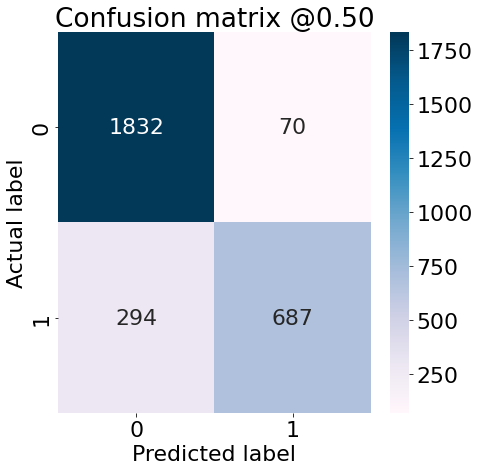

In [138]:
plot_cm(y_test, pred)

In [139]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      1902
           1       0.91      0.70      0.79       981

    accuracy                           0.87      2883
   macro avg       0.88      0.83      0.85      2883
weighted avg       0.88      0.87      0.87      2883



**Отобразим ROC - кривую**

LogisticRegression: ROC AUC=0.938


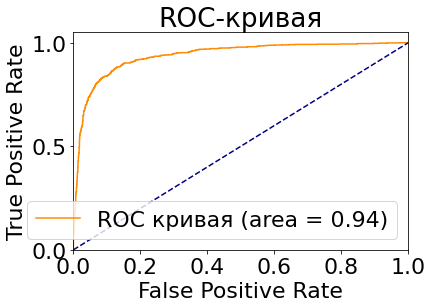

In [140]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = clf.predict_proba(X_test)[:, 1]
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print('LogisticRegression: ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

#**Отобразим топ нейтральных и токсичных слов в текстах датасета**

In [141]:
def wordplot(txt_toxic, txt_neutral):
    
    txt_toxic=' '.join(txt_toxic)
    txt_neutral=' '.join(txt_neutral)

    fig, axs = plt.subplots(figsize=(20, 12))
    plt.axis('off')
    ax = fig.add_subplot(1, 2, 1)

    WIDTH=1600
    HEIGHT=1600
    
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Blues',
                          max_words=200,
                          mask=None
                          ).generate(txt_neutral)
    plt.axis('off')

    FONTSIZE=21
    INTERPOLATION='bilinear'

    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('NEUTRAL \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=1)

    ax = fig.add_subplot(1, 2, 2)
    wordcloud = WordCloud(width=WIDTH,
                          height=HEIGHT,
                          background_color="black",
                          colormap = 'Oranges',
                          max_words=200,
                          mask=None, 
                          ).generate(txt_toxic)
    
    plt.imshow(wordcloud, interpolation=INTERPOLATION)
    plt.title('TOXIC \n', fontsize=FONTSIZE)
    plt.margins(x=1, y=0)
    plt.axis('off')
    plt.show()

In [142]:
feature_to_coef = { word: coef for word, coef in zip(vectorize.get_feature_names_out(), clf.coef_[0]) }

toxic, neutral   = [], []

for best_negative in sorted(feature_to_coef.items(), key=lambda x: x[1], reverse=True)[:50]:
    toxic.append(best_negative[0])

for best_positive in sorted(feature_to_coef.items(), key=lambda x: x[1])[:50]:
    neutral.append(best_positive[0])

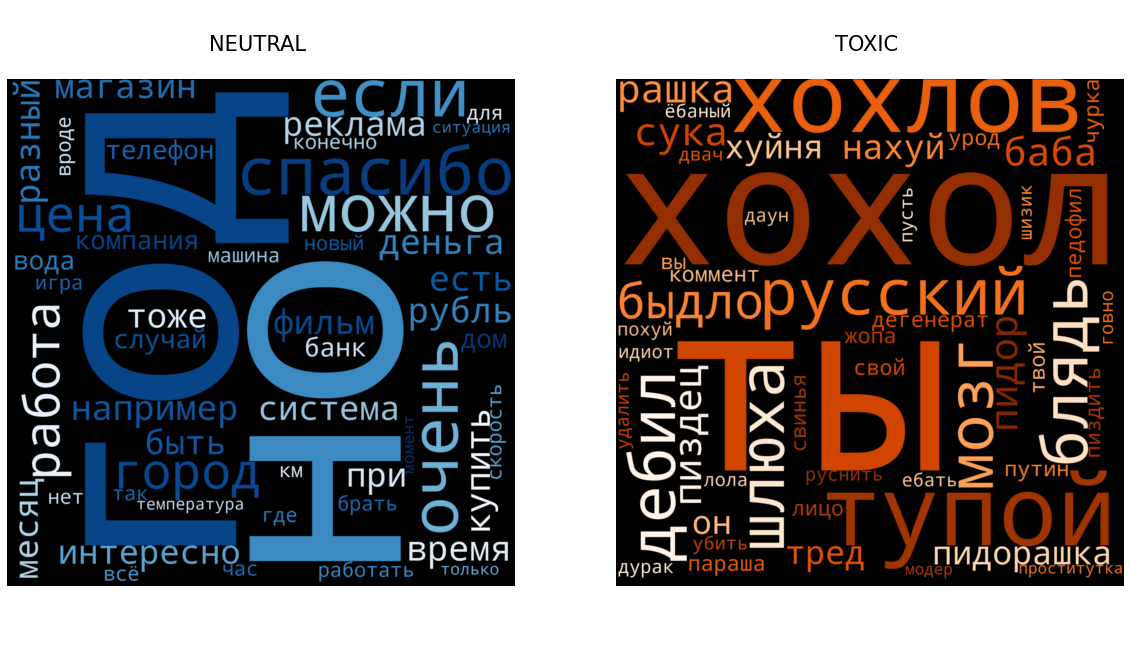

In [143]:
wordplot(toxic, neutral)